#  PyTorch Tutorial 

This is the code accompanying the Neural Network workshop + guest lecture in MATH*4060 during Winter 2025 semester at the University of Guelph. 

The code below follows a functional based approach for educational purposes i.e, no use of classes. This is so that students can familiarize themselves with pyTorch without having to learn object oriented programming, although I highly recommend picking up that skill later in your career.

(42000, 785)
(785, 5000)
(785, 37000)
(784,)


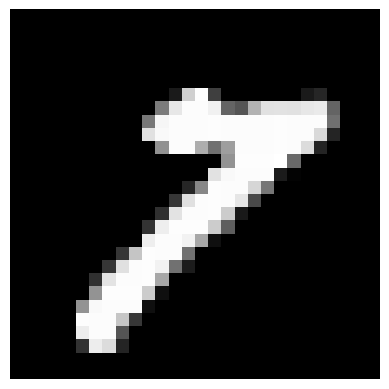

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data and convert to numpy array
data = np.array(pd.read_csv('data/train.csv'))
print(data.shape)

np.random.shuffle(data)

m, n = data.shape

# training split
test = data[0:5000].T
y_test = test[0]
x_test = (test[1:n])/255

# test split
train = data[5000:m].T
y_train = train[0]
x_train = (train[1:n])/255

print(test.shape)
print(train.shape)

print(x_train[:, 420].shape)

# Display image
plt.imshow(x_train[:, 420].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


# Prepare data
x_train_tensor = torch.FloatTensor(x_train.T)  # Shape: [32000, 784]
y_train_tensor = torch.LongTensor(y_train.astype(int))  #  [32000]

x_test_tensor = torch.FloatTensor(x_test.T)  #  [5000, 784]
y_test_tensor = torch.LongTensor(y_test.astype(int)) # [784]

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Create network function
def create_network(input_size, hidden_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, hidden_size), nn.ReLU(),
        nn.Linear(hidden_size, hidden_size), nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )


Using device: cpu


**SELF LEARN**: I highly recommend googling "Cross Entropy Loss", other loss functions and optimization algorithms like adaptive momentum or stochastic gradient descent.

Episode 0, Loss: 216.8399
Episode 50, Loss: 2.7938
Episode 100, Loss: 0.1225
test accuracy: 0.9648


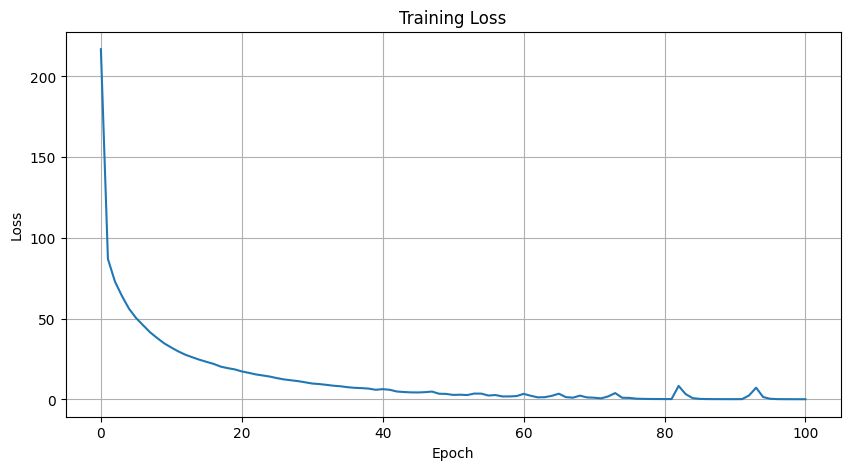

In [ ]:
# Define network parameters
input_size = 784
hidden_size = 32
output_size = 10 # classification problem ergo: 0 - 9 digits to classify

# Create the network
BalkaNet = create_network(input_size, hidden_size, output_size)

# loss criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BalkaNet.parameters(), lr=0.001) # Adaptive momentum optimizer - like SGD but better

loss_history = []

episodes = 101
for ep in range(episodes):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        
        # outputs  from network - "logits"
        outputs = BalkaNet(inputs)
        loss = criterion(outputs, labels) 
        
        running_loss += loss.item()
        
        # zeroing gradient from previously to prevent gradient accumulation
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # tracking total losses from each episode
    loss_history.append(running_loss)
    if ep % 50 == 0:
        print(f"Episode {ep}, Loss: {running_loss:.4f}")
    


# evaluation
BalkaNet.eval()
with torch.no_grad():
    test_outputs = BalkaNet(x_test_tensor)

    # outputs the maximum logit value and index at which max happens
    test_logits, test_predicted = torch.max(test_outputs, 1)

    test_correct = (test_predicted == y_test_tensor).sum().item()
    test_accuracy = test_correct / y_test_tensor.size(0)

print(f"test accuracy: {test_accuracy:.4f}")

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## A note about logits

The raw values from the final layer are called "logits" by convention in machine learning and neural networks. These values are essentially the weighted sum of inputs to that final layer, calculated by the linear transformation (matrix multiplication plus bias): `z = Wx + b`. 

The term "logit" comes from logistic regression, where the log-odds ratio is often called the logit, where `logit(p) = log(p/(1-p))`. Maps `(0,1)` of probability to `(-inf, inf)`. To go back to p, we'd use something like a sigmoid function i.e, `sigmoid(z) = 1/(1+e^(-z))`, where z is the "logit".

In neural networks, this term has been adopted more broadly to refer to the raw, unnormalized outputs of the network before any final activation function like softmax is applied. There's nothing special about these values that inherently makes them "logits" - they're simply the direct outputs of the final linear layer. We call them logits because they serve the same function as logits in logistic regression: they represent unnormalized scores that, after transformation (typically through softmax), can be interpreted as probabilities.

Prediction: 7
Actual: 7


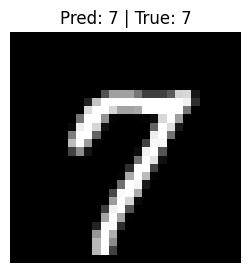

Prediction: 2
Actual: 2


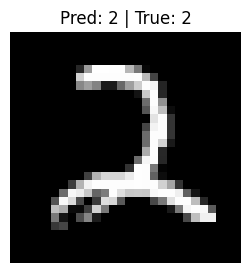

Prediction: 0
Actual: 0


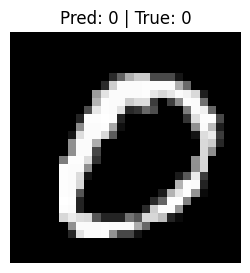

Prediction: 1
Actual: 1


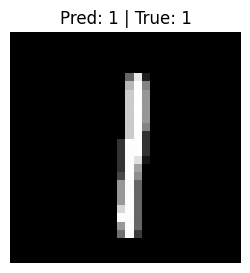

Prediction: 2
Actual: 8


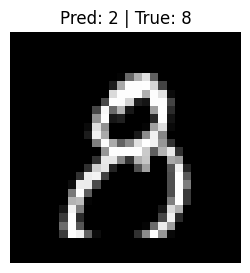

In [29]:
index = 5

for index in range(5):
    BalkaNet.eval()
    with torch.no_grad():
        img = x_test_tensor[index:index+1]
        output = BalkaNet(img)
        max_logit, predicted_img = torch.max(output, 1)

    print(f"Prediction: {predicted_img.item()}")
    print(f"Actual: {y_test_tensor[index].item()}")

    # Display image
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test_tensor[index].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_img.item()} | True: {y_test_tensor[index].item()}")
    plt.axis('off')
    plt.show()


The following code is to convert any image into MNIST format. Ensure cv2 library is installed, if not it can b installed via  `pip install opencv-python`

In [ ]:
import cv2

def preprocess_digit(image_path, target_size=(28, 28)):

    # Read the image and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image {image_path}")
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image - Otsu works well for clear handwriting on white paper
    b, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours to identify the digit
    contours, d = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If contours exist, find the largest one (should be the digit)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Add some padding
        padding = 4
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(binary.shape[1], x + w + padding)
        y_end = min(binary.shape[0], y + h + padding)
        
        # Extract the digit
        digit = binary[y_start:y_end, x_start:x_end]
    else:
        # If no contours found, use the whole image
        digit = binary
    
    # Make square by padding
    h, w = digit.shape
    if h > w:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left
        digit = cv2.copyMakeBorder(digit, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    else:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        digit = cv2.copyMakeBorder(digit, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=0)
    
    # Resize to target size
    digit = cv2.resize(digit, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    mnist_img = digit / 255.0
    
    # Create PyTorch tensor and add batch dimension
    tensor_img = torch.FloatTensor(mnist_img).unsqueeze(0)
    
    # Flatten the tensor to match model input shape (if needed)
    if len(tensor_img.shape) == 3:  # [batch, height, width]
        tensor_img = tensor_img.reshape(1, -1)  # Flatten to [batch, 784]
    
    return mnist_img, tensor_img

# Example usage with visualization
def test_digit_preprocessing(image_path):

    # Preprocess the digit
    mnist_img, tensor_img = preprocess_digit(image_path)
    
    # Display original image
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Show original image
    ax1.imshow(orig_img)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Show processed image
    ax2.imshow(mnist_img, cmap='gray')
    ax2.set_title("Processed Image (MNIST format)")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Tensor shape: {tensor_img.shape}")
    
    return mnist_img, tensor_img


## Testing our trained neural network on handwriting

Make sure you zoom in a lot on your handwritten digit, before you feed into the image processing function 

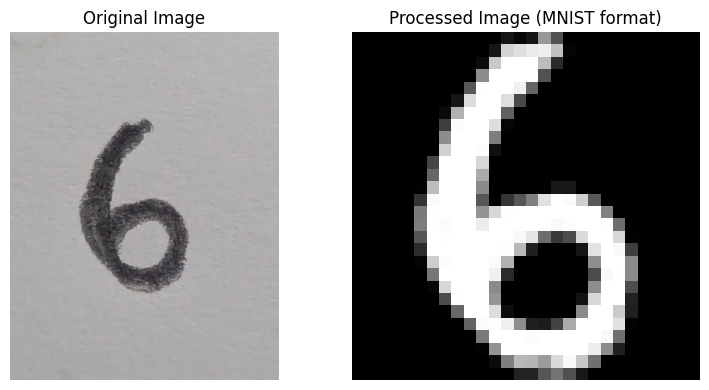

Tensor shape: torch.Size([1, 784])
Prediction: 6


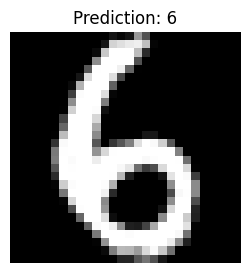

In [ ]:
# load and preprocess custom image

#mnist_img, tensor_img = preprocess_digit("digits/zero.jpg")

# input your image location and image file name 
# processes and prints the converted side by side with the original
mnist_img, tensor_img = test_digit_preprocessing("digits/six.jpg")


# make a prediction
BalkaNet.eval()
with torch.no_grad():
    output = BalkaNet(tensor_img)
    data, predicted = torch.max(output, 1)

# display result
print(f"Prediction: {predicted.item()}")

plt.figure(figsize=(3, 3))
plt.imshow(mnist_img, cmap='gray')
plt.title(f"Prediction: {predicted.item()}")
plt.axis('off')
plt.show()

## Resources

- https://statquest.org/essential-matrix-algebra-for-neural-networks-clearly-explained/
- https://blog.ezyang.com/2019/05/pytorch-internals/
- https://youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&si=PGB3dIskdyQmHopE
- https://nnfs.io/